## Introduction 
Binary classifcation model to predict whether it rains the next day.
### Purpose: 
To explore ML workflows by predicting rainfall

### Selection of openmeteo API:
Easy to access and no requirement of an API key for data retrieval.

# 1. Setup

In [ ]:
#importing required packages 
import openmeteo_requests
from retry_requests import retry 
import requests_cache
from datetime import timedelta
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import type_of_target
import matplotlib.pyplot as plt
import seaborn as sns

#Global seed variable
SEED=0

print("Setup Complete.")

Setup Complete.


# 2. Gathering the data

### <ul><li>Gathering Historic Data from $1^{st}$ Jan, 2022 to October $2^{nd}$, 2025</li></ul>

In [23]:
#URL for historical data from 2022 - 2025
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"


#Creating a cached session to optimize performance with retry mechanism
cached_session = requests_cache.CachedSession('.cache', expire_after=timedelta(days=1))
retry_session = retry(cached_session, retries=5, backoff_factor=0.2)
client = openmeteo_requests.Client(session=retry_session)

#Parameters for historic weather data
params = {
    "latitude": 13.009830,
    "longitude": 77.537437,
    "hourly": ["temperature_2m", "precipitation", "rain", "precipitation_probability", "wind_speed_10m", "wind_direction_10m", "surface_pressure"],
    "start_date": "2022-01-01",
    "end_date": "2025-10-02",
}

#Sending an HTTP request to the API for the required data
responses = client.weather_api(url=url, params=params)
response = responses[0]
print(f"Latitude: {response.Latitude()}")
print(f"Longitude: {response.Longitude()}")
print(f"Elevation: {response.Elevation()}")

#Processing the hourly variables to Numpy Arrays 
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["surface_pressure"] = hourly_surface_pressure

historic_data = pd.DataFrame(data=hourly_data)

#Saving the data to a csv for easy access without multiple API requests 
historic_data.to_csv("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/weather_data.csv", index=False)




Latitude: 13.0
Longitude: 77.5
Elevation: 883.0


### <ul><li>Gathering Data on October $3^{rd}$, 2025. This will be used for testing.</li></ul>

In [24]:
#Data for October 3rd, 2025 to validate model
url_current = "https://api.open-meteo.com/v1/forecast"

#Parameters for current weather data
params = {
    "latitude": 13.009830,
    "longitude": 77.537437,
    "hourly": ["temperature_2m", "precipitation", "rain", "precipitation_probability", "wind_speed_10m", "wind_direction_10m", "surface_pressure"],
    "start_date": "2025-10-03",
    "end_date": "2025-10-03"
}

#Sending an HTTP request to the API for the required data
responses = client.weather_api(url=url, params=params)
response = responses[0]
print(f"Latitude: {response.Latitude()}")
print(f"Longitude: {response.Longitude()}")
print(f"Elevation: {response.Elevation()}")

#Processing the hourly variables to Numpy Arrays 
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation_probability = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m= hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["surface_pressure"] = hourly_surface_pressure

validation_data = pd.DataFrame(hourly_data)

validation_data.to_csv("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/validation_data.csv", index=False)

Latitude: 13.0
Longitude: 77.5
Elevation: 883.0


In [3]:
# Reading the saved training data CSV file
prediction_data_path = "//Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/weather_data.csv"
prediction_data = pd.read_csv(prediction_data_path, parse_dates=True)

prediction_data.head()

date  ...  surface_pressure
0  2022-01-01 00:00:00+00:00  ...         917.58264
1  2022-01-01 01:00:00+00:00  ...         918.10815
2  2022-01-01 02:00:00+00:00  ...         918.67110
3  2022-01-01 03:00:00+00:00  ...         919.72190
4  2022-01-01 04:00:00+00:00  ...         919.84880

[5 rows x 8 columns]

In [6]:
#Find columns with missing values
preds_data = prediction_data.copy()
na_counts = preds_data.isna().sum()
print(f"NA Counts:\n{na_counts}\n\n")

num_rows = preds_data.shape[0]

print(f"Number of Rows = {num_rows}\n\n")

print(f"Percent NA:\n{(na_counts/num_rows) * 100}")

NA Counts:
date                             0
temperature_2m                   0
precipitation                    0
rain                             0
precipitation_probability    30459
wind_speed_10m                   0
wind_direction_10m               0
surface_pressure                 0
dtype: int64


Number of Rows = 32904


Percent NA:
date                          0.000000
temperature_2m                0.000000
precipitation                 0.000000
rain                          0.000000
precipitation_probability    92.569292
wind_speed_10m                0.000000
wind_direction_10m            0.000000
surface_pressure              0.000000
dtype: float64


## 3. Prerocessing and identifying the feature and target variables
### Approach 1: NaN values in the precipitation_probability column is replaced with 0.

In [19]:
def train(model, X_train, y_train, X_valid):
    """A single method that calls train and predict given the model type

    Args:
        model (RandomForestClassifier): Classifier model for training and prediction
        X_train (DataFrame): Training feature data
        y_train (Series): Training target data
        X_valid (_type_): Validation feature data

    Returns:
        ndarray: A series of the predicted values
    """
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    
    return preds

In [7]:
def evaluate(y_true, y_pred):
    """A method to evaluate a binary classification model and returns a list of the accuracy, recall, precision

    Args:
        y_true (DataFrame): _description_
        y_pred (Series): _description_

    Returns:
        Dict: List of accuracy, recall, precision
    """
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return {"accuracy":accuracy, 
            "recall":recall, 
            "precision":precision}

In [ ]:
#Adding a boolean mask for rain or no rain 
precipitation_probability = preds_data["precipitation_probability"]
precipitation_probability.fillna(0.0, inplace=True)

preds_data["rain or no rain"] = (precipitation_probability >= 60.0).astype(int)

pos_count = preds_data["rain or no rain"].sum()

print(f"Positive Count = {pos_count}")
print(f"Negative Count = {preds_data["rain or no rain"].shape[0]-pos_count}")


#Assigning features and target
feature_cols = ["temperature_2m", "precipitation", "rain", "wind_speed_10m", "wind_direction_10m", "surface_pressure"]

X = preds_data[feature_cols]

y = preds_data["rain or no rain"]

print(y.size)

# #Splitting training and testing datasets 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)

#sns.boxenplot(X, orient='y')
#fig, axs = plt.subplots(ncols=6)
#sns.histplot(X["temperature_2m"])
#sns.histplot(X["precipitation"])
# sns.histplot(X["rain"])
# sns.histplot(X["surface_pressure"])
# sns.histplot(X["wind_direction_10m"])
# sns.histplot(X["wind_speed_10m"])


Positive Count = 258
Negative Count = 32646
32904


In [ ]:
#Defining the model
model_1 = RandomForestClassifier(n_estimators=100,random_state=SEED)

#Training and fitting the model
model_1.fit(X_train, y_train)
preds_1 = model_1.predict(X_valid)

#Evaluating the model
scores_1 = evaluate(y_valid, preds_1)

#Creating a bar plot of the accuracy, recall, precision for the training data
sns.barplot(data=scores_1, orient='y')
plt.savefig("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/approach1_valid.jpg")




In [9]:
#Importing the dataset for testing the prediction
test_data = pd.read_csv("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/validation_data.csv")

#Identifying feature and targets for the testing data
X_test = test_data[feature_cols]
y_test = (test_data["precipitation_probability"] >= 60).astype(int)


In [ ]:
Predicting with the validation features
val_preds = model_1.predict(X_test)

#Validating model with true data
test_1_scores = evaluate(y_test, val_preds)

#Creating a bar plot of the accuracy, recall, precision for the testing data
sns.barplot(data=test_1_scores, orient='y')
plt.savefig("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/approach1_test.jpg")



### Approach 2: Dropping the rows containing the NaN values

In [27]:
#Dropping NaN values
prediction_data_2 = prediction_data.copy()

prediction_data_2 = prediction_data_2.dropna(axis=0)

# print(prediction_data_2.isna().any().all())
#prediction_data_2.head()

print(f"Percent Loss = {(prediction_data.shape[0] - prediction_data_2.shape[0])/prediction_data.shape[0]}")

probabilities_2 = prediction_data_2["precipitation_probability"]

prediction_data_2["rain or no rain"] = (probabilities_2>=60).astype(int)

# #Identifying feature and target 
X_2 = prediction_data_2[feature_cols]

y_2 = prediction_data_2["rain or no rain"]

pos_2_count = prediction_data_2["rain or no rain"].sum()
print(f"Positive Count = {pos_2_count}")
print(f"Negative Count = {prediction_data_2["rain or no rain"].shape[0]-pos_2_count}")



# #Splitting the training and testing data
X_2_train, X_2_valid, y_2_train, y_2_valid = train_test_split(X_2, y_2, random_state=SEED)

Percent Loss = 0.925692924872356
Positive Count = 258
Negative Count = 2187


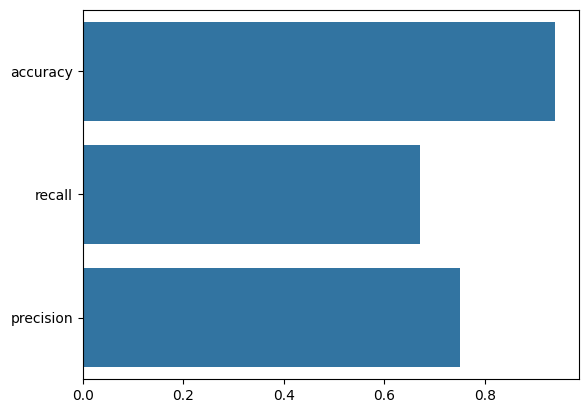

In [30]:
model_2 = RandomForestClassifier(n_estimators=150, random_state=SEED)

#Training the model
model_2.fit(X_2_train, y_2_train)

#Predicting
preds = model_2.predict(X_2_valid)

#Evaluating the model
scores_2 = evaluate(y_2_valid, preds)

#Creating a bar plot and saving to file
sns.barplot(data=scores_2, orient='y')
plt.savefig("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/approach2_valid.jpg")

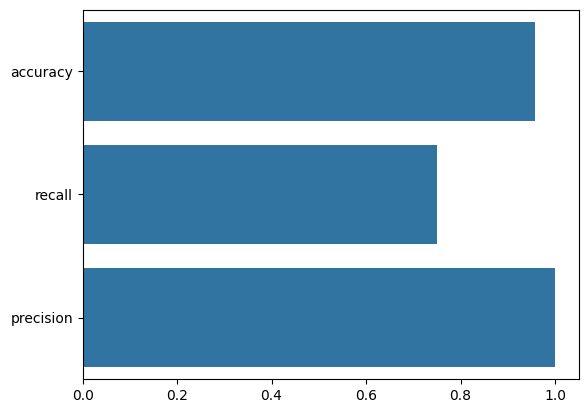

In [32]:
preds_2 = model_2.predict(X_test)

test_2_scores = evaluate(y_test, preds_2)

sns.barplot(data=test_2_scores, orient='y')
plt.savefig("/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/approach2_test.jpg")

### Approach 3: Imputing

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

spltter = TimeSeriesSplit()
preds_data_3 = prediction_data.copy()

precipitation_probabilities = pd.DataFrame(preds_data_3["precipitation_probability"])

#Defining our imputer
imputer = SimpleImputer(strategy='mean')

#Imputing the training and validation targets
imputed_probabilities = pd.DataFrame(imputer.fit_transform(precipitation_probabilities))

#Adding the columns back to the imputed training and validation features
imputed_probabilities.columns = precipitation_probabilities.columns

#Identifying feature and target
X_3 = preds_data_3[feature_cols]
y_3 = (imputed_probabilities["precipitation_probability"] >= 60).astype(int)

#Splitting the data
X_3_train, X_3_valid, y_3_train, y_3_valid = TimeSeriesSplit(X_3, y_3, test_size=0.8, train_size=0.2, random_state=SEED)

0.004672897196261682


<Axes: >

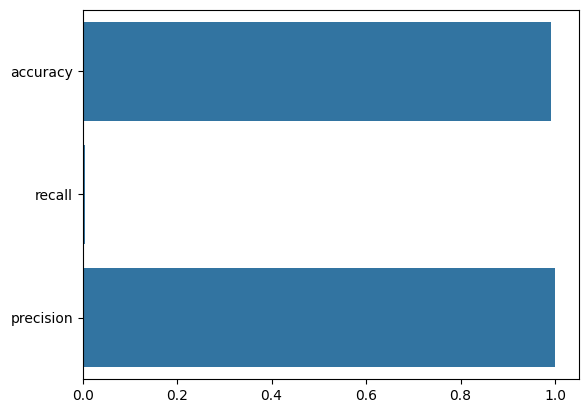

In [ ]:


#Defining our Classifier Model
model_3 = RandomForestClassifier(n_estimators=500, random_state=SEED)

#Fitting our model to the training data
model_3.fit(X_3_train, y_3_train)

#Predicting our model 
preds_3 = model_3.predict(X_3_valid)

scores_3 = evaluate(y_3_valid, preds_3)


print(f"{scores_3["recall"]}")

sns.barplot(scores_3, orient='y')

### Approach with time series splitting

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

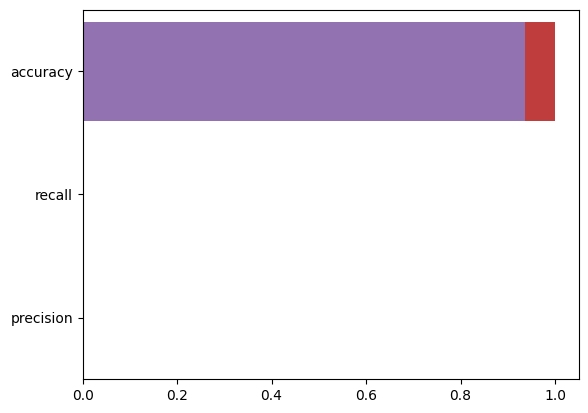

In [26]:
from sklearn.model_selection import TimeSeriesSplit

#Making a copy of the dataframe
time_series = prediction_data.copy()

probabilities = time_series["precipitation_probability"].fillna(0.0)

time_series["rain or no rain"] = (probabilities >= 50.0).astype(int)

#Identifying feature and target
ts_feature_cols = ["temperature_2m", "rain", "wind_speed_10m", "wind_direction_10m", "surface_pressure"]
X = time_series[ts_feature_cols]
y = time_series["rain or no rain"]

#Initializing a model 
model = RandomForestClassifier(n_estimators = 100)
#Splitting the data
tss = TimeSeriesSplit(n_splits=5)
for i, (train_index, test_index) in enumerate(tss.split(X, y)):
    preds = train(model, X_train=X.iloc[train_index], y_train=y.iloc[train_index], X_valid=X.iloc[test_index])
    scores = evaluate(y.iloc[test_index], preds)
    sns.barplot(scores, orient='y')
    
    plt.savefig(f"/Users/aniruddhasharma/Library/Mobile Documents/com~apple~CloudDocs/Documents/Career/Projects/Rain Prediction/TimeSeries_Fold_{i}")

In [ ]:
#TODO: For every train and test index, fit and predict a model and validate
